### Load libraries

In [1]:
import dataclasses
import os
import pathlib
import random
from collections import defaultdict
from typing import List, Dict, Union

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportion_confint

plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": ["Times"],
        "text.usetex": True,
        "pgf.rcfonts": False,
        "font.size": 10,
        "font.weight": "medium",
    }
)
plt.style.use("tableau-colorblind10")

In [2]:
import sys

sys.path.append("../../../parsing_server")
import game_info

In [3]:
# If on Tom's computer, use
# HARDENED_PREFIX = /Users/t/code/far/data/
HARDENED_PREFIX = "/nas/ucb/k8/go-attack/match/"

### Utilities

In [4]:
def parse_for_match(df: pd.DataFrame, victim_name_prefix="cp505-v"):
    adv_is_black = df.b_name.str.contains("adv")
    adv_is_white = df.w_name.str.contains("adv")
    victim_is_black = ~adv_is_black
    victim_is_white = ~adv_is_white
    assert (~adv_is_black == adv_is_white).all()

    df.loc[adv_is_black, "adv_name"] = df.b_name[adv_is_black]
    df.loc[adv_is_white, "adv_name"] = df.w_name[adv_is_white]
    df.loc[adv_is_black, "adv_color"] = "b"
    df.loc[adv_is_white, "adv_color"] = "w"

    df.loc[victim_is_black, "victim_name"] = df.b_name[victim_is_black]
    df.loc[victim_is_white, "victim_name"] = df.w_name[victim_is_white]
    df.loc[victim_is_black, "victim_color"] = "b"
    df.loc[victim_is_white, "victim_color"] = "w"

    df.adv_win = df.adv_color == df.win_color

    df.victim_visits = df.victim_name.str.slice(start=len(victim_name_prefix)).astype(
        int
    )

### cp505 vs cp127

In [5]:
match_path = pathlib.Path("/nas/ucb/tony/go-attack/matches/cp127-vs-cp505/summary.txt")
lines = match_path.read_text().splitlines()

elo_lines_start_idx = lines.index("Elos (+/- one approx standard error):")
elo_lines_end_idx = lines.index(
    "Pairwise approx % likelihood of superiority of row over column:"
)
elo_lines = lines[elo_lines_start_idx + 1 : elo_lines_end_idx]

bot_entries: List[Dict[str, Union[float, int, str]]] = []
for elo_line in elo_lines:
    name = elo_line.split(" ")[0]
    bot_entries.append(
        {
            "name": name.split("-v")[0],
            "visits": int(name.split("-v")[1]),
            "elo": float(elo_line.split(":")[1].split("+/-")[0]),
            "std": float(elo_line.split("+/-")[1]),
        }
    )

df = pd.DataFrame(bot_entries)
df.head()
df.elo -= df.elo.min()

2355.24


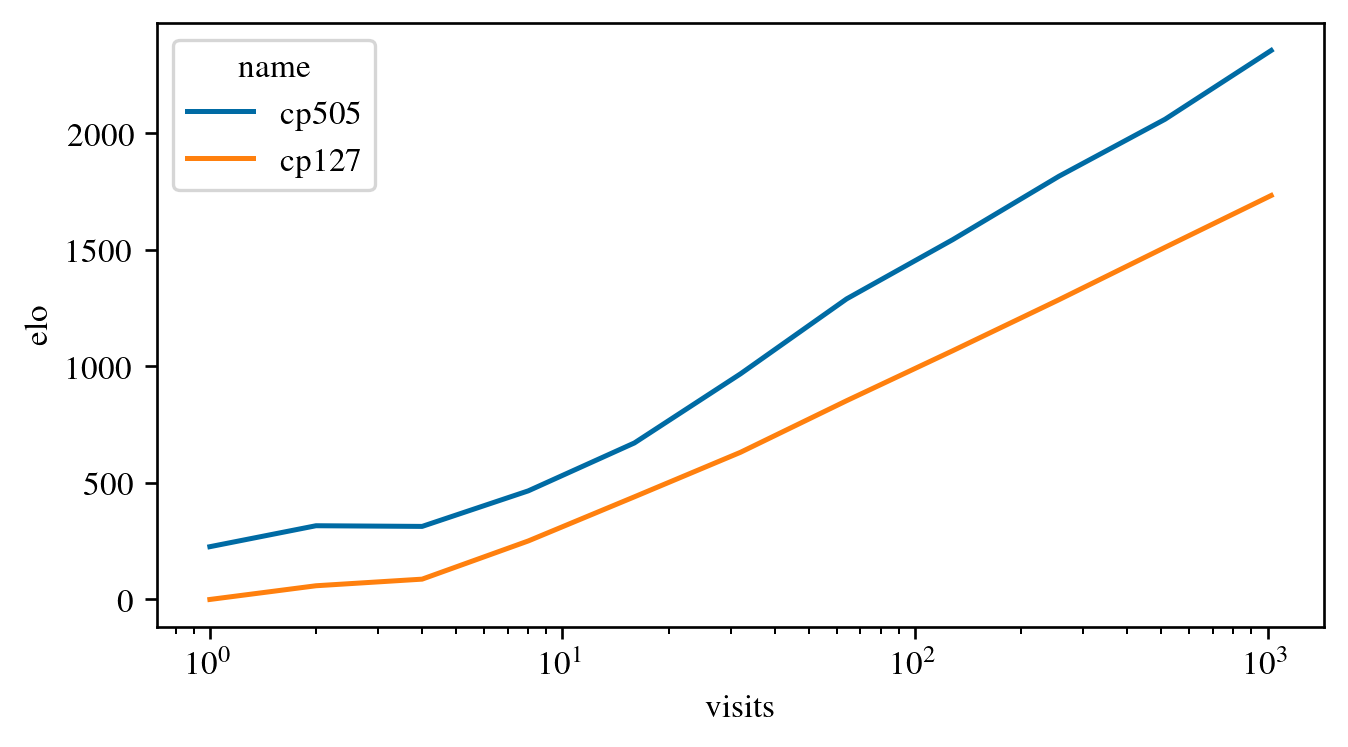

In [6]:
print(df.elo.max())
fig, axs = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(5.50107, 3),
    dpi=240,
    gridspec_kw={"height_ratios": [10]},
)
sns.lineplot(data=df, x="visits", y="elo", hue="name")
plt.xscale("log")

### Perfect victim modeling cp505

In [7]:
sgf_paths1 = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-perfect-victim-modeling")
)
sgf_paths2 = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-ov1")
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths1,
        fast_parse=True,
    )
) + list(
    game_info.read_and_parse_all_files(
        sgf_paths2,
        fast_parse=True,
    )
)

df = pd.DataFrame(game_infos)
parse_for_match(df)

In [8]:
print(df.victim_name.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['cp505-v1' 'cp505-v16' 'cp505-v4' 'cp505-v64' 'cp505-v128' 'cp505-v32'
 'cp505-v8' 'cp505-v2' 'cp505-v256' 'cp505-v512']
[  1  16   4  64 128  32   8   2 256 512]
['adv-s34090496-v200' 'adv-s34090496-v200-ov1']


In [9]:
len(df.query("adv_name == 'adv-s34090496-v200' and victim_visits == 128"))

80

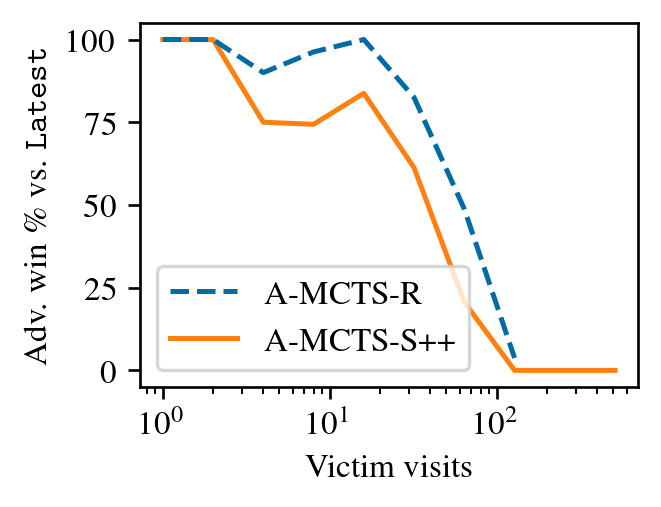

In [10]:
fig, axs = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(2.64049, 2),
    dpi=240,
    gridspec_kw={"height_ratios": [10]},
)

(
    100
    * df.query("adv_name == 'adv-s34090496-v200' & victim_visits <= 128")
    .groupby("victim_visits")
    .mean(numeric_only=True)
    .adv_win
).plot(label="A-MCTS-R", zorder=10, linestyle="--")
(
    100
    * df.query("adv_name == 'adv-s34090496-v200-ov1'")
    .groupby("victim_visits")
    .mean(numeric_only=True)
    .adv_win
).plot(label="A-MCTS-S++")

plt.ylim(-5, 105)
plt.xscale("log")
plt.ylabel("Adv. win \\% vs. $\\texttt{Latest}$")
# plt.title("Adversary against cp505")
plt.xlabel("Victim visits")
plt.legend()

plt.savefig("adv-vs-cp505-vary-visits.pgf", backend="pgf")

### Perfect victim modeling cp505 with avoid-pass-alive hardening

In [11]:
sgf_paths = game_info.find_sgf_files(
    pathlib.Path(f"{HARDENED_PREFIX}/ttseng-hard-vic-v-sweep-20221108-182437")
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )
)

df = pd.DataFrame(game_infos)
parse_for_match(df)
len(df)

2880

In [12]:
print(df.victim_name.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())
len(df.query("adv_name == 'adv-s349284096-v200' and victim_visits == 128"))

['cp505-v256' 'cp505-v128' 'cp505-v8' 'cp505-v64' 'cp505-v32' 'cp505-v2'
 'cp505-v1' 'cp505-v16' 'cp505-v4' 'cp505-v512']
[256 128   8  64  32   2   1  16   4 512]
['adv-s349284096-v200' 'adv-s349284096-v200-ov1']


122

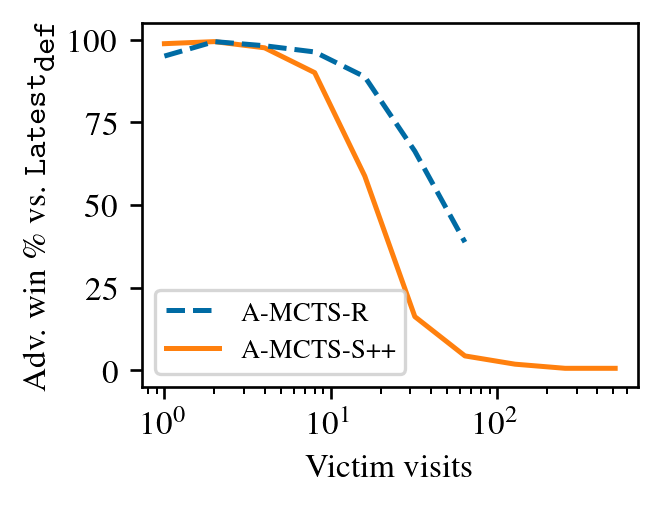

In [13]:
fig, axs = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(2.64049, 2),
    dpi=240,
    gridspec_kw={"height_ratios": [10]},
)

(
    100
    * df.query("adv_name == 'adv-s349284096-v200' & victim_visits <= 64")
    .groupby("victim_visits")
    .mean(numeric_only=True)
    .adv_win
).plot(label="A-MCTS-R", zorder=10, linestyle="--")
(
    100
    * df.query("adv_name == 'adv-s349284096-v200-ov1'")
    .groupby("victim_visits")
    .mean(numeric_only=True)
    .adv_win
).plot(label="A-MCTS-S++")

plt.ylim(-5, 105)
plt.xscale("log")
plt.ylabel("Adv. win \\% vs. $\\texttt{Latest}_\\texttt{def}$")
# plt.title("Adversary against cp505")
plt.xlabel("Victim visits")
# plt.legend()
# smaller font size to avoid covering up points
plt.legend(prop={"size": 8})

plt.savefig("adv-vs-cp505h-vary-visits.pgf", backend="pgf")

In [14]:
print(df.query("adv_name == 'adv-s349284096-v200-ov1'").groupby("victim_visits").mean(numeric_only=True).adv_win)
print(df.query("adv_name == 'adv-s349284096-v200'").groupby("victim_visits").mean(numeric_only=True).adv_win)

victim_visits
1      0.98750
2      0.99375
4      0.97500
8      0.90000
16     0.58750
32     0.16250
64     0.04375
128    0.01875
256    0.00625
512    0.00625
Name: adv_win, dtype: float64
victim_visits
1      0.950000
2      0.993750
4      0.981250
8      0.962500
16     0.887500
32     0.662500
64     0.387500
128    0.172131
256    0.210526
Name: adv_win, dtype: float64


### Perfect victim modeling cp127 (old adversary)

In [15]:
sgf_paths = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/tony/go-attack/matches/cp127-perfect-victim-modeling/sgfs")
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )
)

df = pd.DataFrame(game_infos)
parse_for_match(df)

In [16]:
print(df.victim_name.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['cp127-v4' 'cp127-v8' 'cp127-v16' 'cp127-v64' 'cp127-v32' 'cp127-v1'
 'cp127-v2']
[ 4  8 16 64 32  1  2]
['adv-s35783424-v200' 'adv-s35783424-v200-ov1'
 'adv-s35783424-v200-ov1-os1']


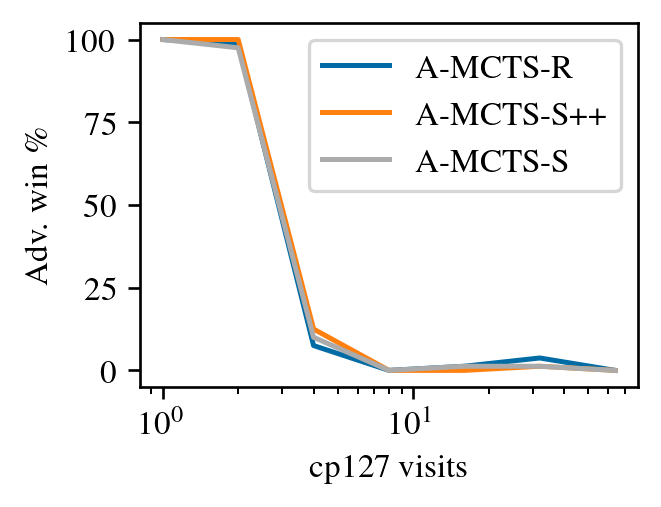

In [17]:
fig, axs = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(2.64049, 2),
    dpi=240,
    gridspec_kw={"height_ratios": [10]},
)

(
    100
    * df.query("adv_name == 'adv-s35783424-v200'")
    .groupby("victim_visits")
    .mean(numeric_only=True)
    .adv_win
).plot(label="A-MCTS-R")
(
    100
    * df.query("adv_name == 'adv-s35783424-v200-ov1'")
    .groupby("victim_visits")
    .mean(numeric_only=True)
    .adv_win
).plot(label="A-MCTS-S++")
(
    100
    * df.query("adv_name == 'adv-s35783424-v200-ov1-os1'")
    .groupby("victim_visits")
    .mean(numeric_only=True)
    .adv_win
).plot(label="A-MCTS-S")

plt.ylim(-5, 105)
plt.xscale("log")
plt.ylabel("Adv. win \\%")
# plt.title("Adversary against cp127")
plt.xlabel("cp127 visits")
plt.legend()

### Strongest cp127 adversary

In [18]:
sgf_paths = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/tony/go-attack/matches/cp127-cp505-vs-strong-adv/sgfs/")
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )
)

df = pd.DataFrame(game_infos)
parse_for_match(df)
df["victim_net"] = df.victim_name.str.slice(stop=len("cp505"))
len(df)

8916

In [19]:
print(df.victim_name.unique())
print(df.victim_net.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['cp505-v32' 'cp505-v2' 'cp505-v1024' 'cp505-v16' 'cp505-v1' 'cp127-v32'
 'cp505-v8' 'cp127-v16' 'cp127-v256' 'cp505-v512' 'cp127-v2' 'cp127-v64'
 'cp127-v1' 'cp127-v8' 'cp127-v512' 'cp127-v4' 'cp505-v128' 'cp127-v128'
 'cp505-v4' 'cp505-v64' 'cp127-v1024' 'cp505-v256']
['cp505' 'cp127']
[  32    2 1024   16    1    8  256  512   64    4  128]
['adv-s178977536-os1' 'adv-s158012928' 'adv-s180832768-os1'
 'adv-s157014016-os1' 'adv-s180832768' 'adv-s179976704' 'adv-s157014016'
 'adv-s158012928-os1' 'adv-s179976704-os1' 'adv-s178977536']


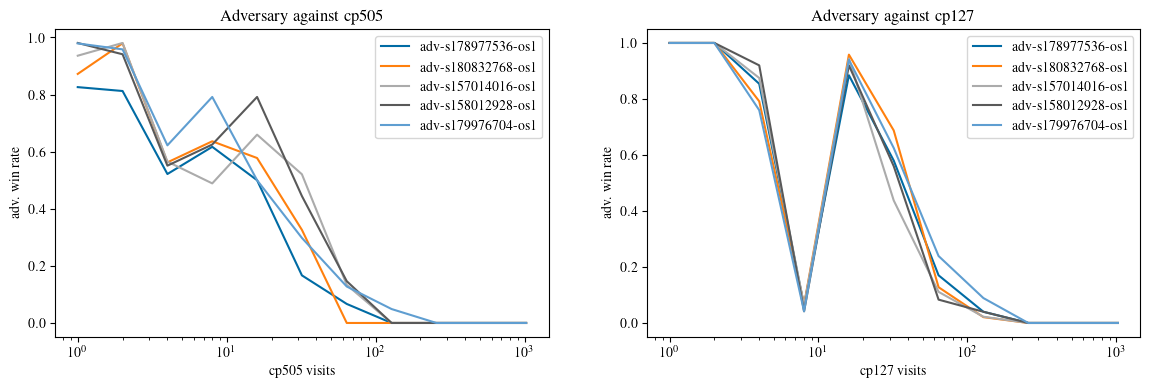

In [20]:
plt.figure(figsize=(14, 4))

victim_net: str
adv_name: str
for i, victim_net in enumerate(df.victim_net.unique()):
    plt.subplot(1, 2, i + 1)
    for adv_name in df.adv_name.unique():
        if not adv_name.endswith("-os1"):
            continue
        df.query(f"adv_name == '{adv_name}' & victim_net == '{victim_net}'").groupby(
            "victim_visits"
        ).mean(numeric_only=True).adv_win.plot(label=adv_name)

    plt.xscale("log")
    plt.ylabel("adv. win rate")
    plt.title(f"Adversary against {victim_net}")
    plt.xlabel(f"{victim_net} visits")
    plt.legend()

### Strongest cp505 adversary

In [21]:
sgf_paths = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-adv-emcts1.4/sgfs")
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )
)

df = pd.DataFrame(game_infos)

# Filter out games with two adversaries
adv_is_black = df.b_name.str.contains("adv")
adv_is_white = df.w_name.str.contains("adv")
df = df[~(adv_is_black & adv_is_white)].copy()
parse_for_match(df, victim_name_prefix="bot-cp127-v")
df["victim_net"] = df.victim_name.str.slice(start=len("bot-"), stop=len("bot-cp505"))
len(df)

10932

In [22]:
print(df.victim_name.unique())
print(df.victim_net.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['bot-cp127-v8' 'bot-cp505-v32' 'bot-cp505-v16' 'bot-cp127-v256'
 'bot-cp127-v2' 'bot-cp127-v512' 'bot-cp127-v64' 'bot-cp505-v8'
 'bot-cp127-v16' 'bot-cp127-v32' 'bot-cp127-v4' 'bot-cp127-v1'
 'bot-cp505-v1' 'bot-cp505-v128' 'bot-cp505-v64' 'bot-cp127-v128'
 'bot-cp505-v2' 'bot-cp505-v512' 'bot-cp505-v256' 'bot-cp505-v4']
['cp127' 'cp505']
[  8  32  16 256   2 512  64   4   1 128]
['adv-cp505-v1-s34090496-v600' 'adv-cp505-v1-s59042304-v600']


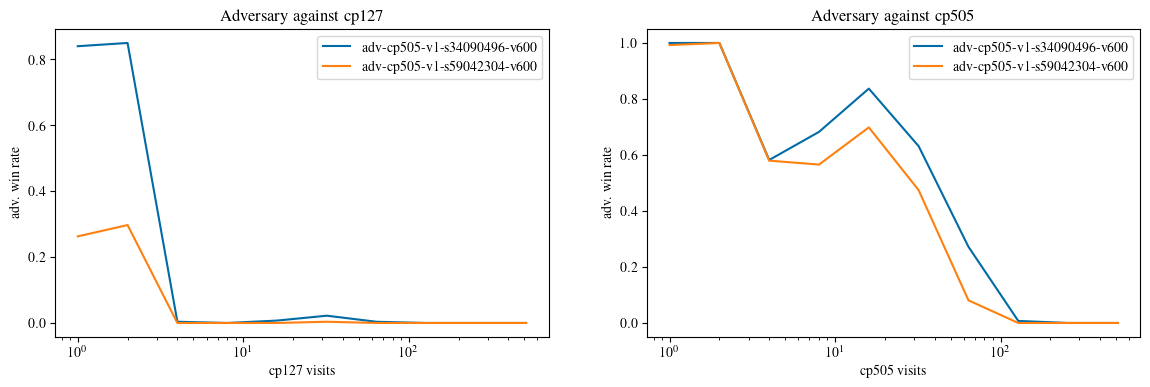

In [23]:
plt.figure(figsize=(14, 4))

victim_net: str
adv_name: str
for i, victim_net in enumerate(df.victim_net.unique()):
    plt.subplot(1, 2, i + 1)
    for adv_name in df.adv_name.unique():
        df.query(f"adv_name == '{adv_name}' & victim_net == '{victim_net}'").groupby(
            "victim_visits"
        ).mean(numeric_only=True).adv_win.plot(label=adv_name)

    plt.xscale("log")
    plt.ylabel("adv. win rate")
    plt.title(f"Adversary against {victim_net}")
    plt.xlabel(f"{victim_net} visits")
    plt.legend()

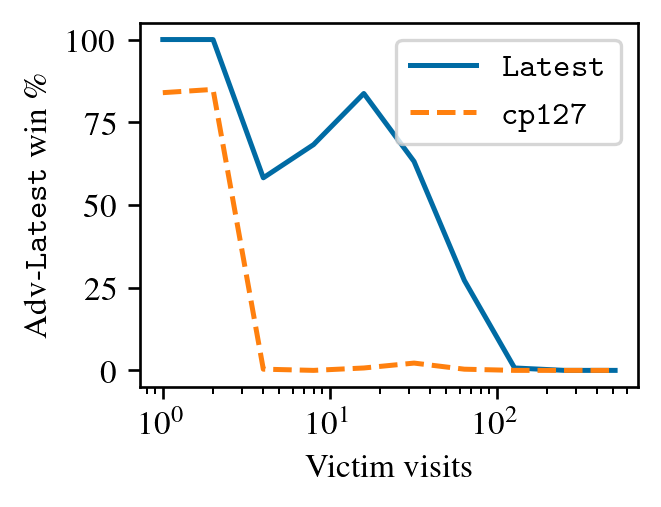

In [24]:
fig, axs = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(2.64049, 2),
    dpi=240,
    gridspec_kw={"height_ratios": [10]},
)

adv_name: str = "adv-cp505-v1-s34090496-v600"
victim_net: str
for victim_net in reversed(df.victim_net.unique()):
    (
        100
        * df.query(f"adv_name == '{adv_name}' & victim_net == '{victim_net}'")
        .groupby("victim_visits")
        .mean(numeric_only=True)
        .adv_win
    ).plot(
        label="$\\texttt{Latest}$" if victim_net == "cp505" else "$\\texttt{cp127}$",
        linestyle="--" if victim_net == "cp127" else None,
    )

plt.ylim(-5, 105)
plt.xscale("log")
plt.ylabel("Adv-$\\texttt{Latest}$ win \\%")
# plt.title("cp505 adversary vs. victims")
plt.xlabel("Victim visits")
plt.legend()

plt.savefig("adv505-transfer.pgf", backend="pgf")

### b10 cp127 adversary

In [25]:
sgf_paths = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/ttseng/go_attack/match/b10-vs-v1to1024/sgfs")
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )
)

df = pd.DataFrame(game_infos)
parse_for_match(df, victim_name_prefix="bot-cp505-v")
df["victim_net"] = df.victim_name.str.slice(start=len("bot-"), stop=len("bot-cp505"))
len(df)

1100

In [26]:
print(df.victim_name.unique())
print(df.victim_net.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())

['bot-cp505-v2' 'bot-cp127-v2' 'bot-cp127-v32' 'bot-cp127-v1'
 'bot-cp127-v16' 'bot-cp505-v1' 'bot-cp505-v4' 'bot-cp505-v256'
 'bot-cp127-v512' 'bot-cp127-v64' 'bot-cp505-v512' 'bot-cp505-v8'
 'bot-cp505-v1024' 'bot-cp127-v256' 'bot-cp127-v8' 'bot-cp505-v128'
 'bot-cp505-v16' 'bot-cp127-v4' 'bot-cp505-v32' 'bot-cp127-v1024'
 'bot-cp505-v64' 'bot-cp127-v128']
['cp505' 'cp127']
[   2   32    1   16    4  256  512   64    8 1024  128]
['adv-s230746880-d58018066-v600']


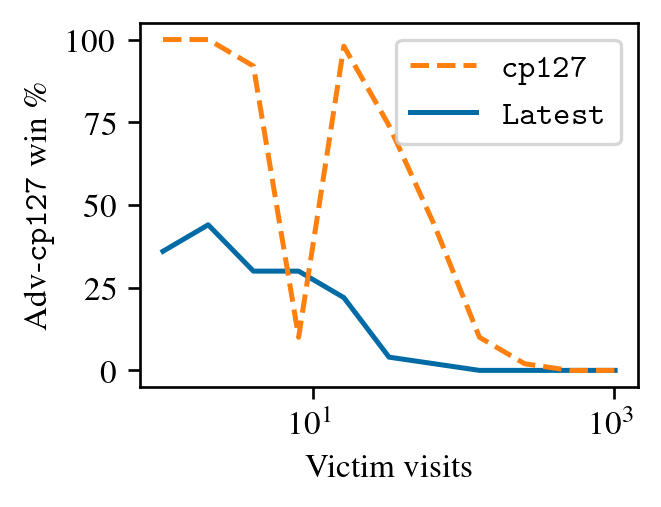

In [27]:
fig, axs = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(2.64049, 2),
    dpi=240,
    gridspec_kw={"height_ratios": [10]},
)

victim_net: str
for victim_net in df.victim_net.unique():
    (
        100
        * df.query(f"victim_net == '{victim_net}'")
        .groupby("victim_visits")
        .mean(numeric_only=True)
        .adv_win
    ).plot(
        label="$\\texttt{Latest}$" if victim_net == "cp505" else "$\\texttt{cp127}$",
        linestyle="--" if victim_net == "cp127" else None,
    )

plt.ylim(-5, 105)
plt.xscale("log")
plt.ylabel("Adv-$\\texttt{cp127}$ win \\%")
# plt.title("cp505 adversary vs. victims")
plt.xlabel("Victim visits")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
# plt.legend();
plt.savefig("adv127-transfer.pgf", backend="pgf")

### Vary adversary visits

In [28]:
sgf_paths = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-v64-vs-adv-1-to-8192/sgfs")
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )
)

df = pd.DataFrame(game_infos)
parse_for_match(df)
# df["victim_net"] = df.victim_name.str.slice(start=len("bot-"), stop=len("bot-cp505"))
len(df)

720

In [29]:
print(df.victim_name.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())
print(df.adv_visits.unique())

['cp505-v64']
[64]
['adv-v8192' 'adv-v2048' 'adv-v32' 'adv-v128' 'adv-v4096' 'adv-v4'
 'adv-v8' 'adv-v1' 'adv-v16' 'adv-v64' 'adv-v512' 'adv-v1024' 'adv-v256'
 'adv-v2']
[8192 2048   32  128 4096    4    8    1   16   64  512 1024  256    2]


In [30]:
sgf_paths1 = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-perfect-victim-modeling")
)
sgf_paths2 = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/tony/go-attack/matches/cp505-ov1")
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths1,
        fast_parse=True,
    )
) + list(
    game_info.read_and_parse_all_files(
        sgf_paths2,
        fast_parse=True,
    )
)

df2 = pd.DataFrame(game_infos)
parse_for_match(df2)

In [31]:
gb = (
    df2.query("victim_visits == 64").groupby("adv_name").mean(numeric_only=True).adv_win
)
gb

adv_name
adv-s34090496-v200        0.48750
adv-s34090496-v200-ov1    0.20625
Name: adv_win, dtype: float64

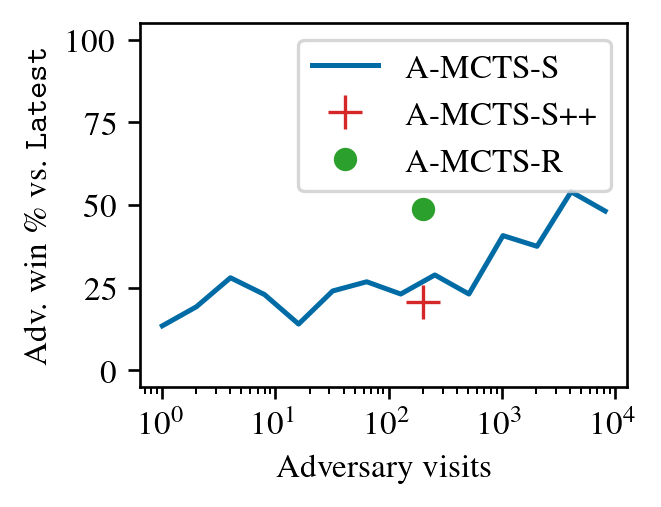

In [32]:
fig, ax = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(2.64049, 2),
    dpi=240,
    gridspec_kw={"height_ratios": [10]},
)

(100 * df.groupby("adv_visits").mean(numeric_only=True).adv_win).plot(label="A-MCTS-S")

plt.plot(
    200,
    100 * gb["adv-s34090496-v200-ov1"],
    "+",
    label="A-MCTS-S++",
    markersize=10,
    color="tab:red",
)

plt.plot(
    200,
    100 * gb["adv-s34090496-v200"],
    "o",
    label="A-MCTS-R",
    markersize=6,
    color="tab:green",
)

# plt.title("adv. vs cp505@64")
plt.ylim(-5, 105)
plt.xscale("log")

# https://stackoverflow.com/a/73094650/1337463
from matplotlib import ticker as mticker

ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.xlabel(f"Adversary visits")
plt.ylabel("Adv. win \\% vs. $\\texttt{Latest}$")
plt.legend()
plt.savefig("adv-vs-cp505-vary-visits2.pgf", backend="pgf")

### Vary adversary visits vs. avoid-pass-alive victim 

In [33]:
# note(tomtseng): this should be
# /nas/ucb/k8/go-attack/match/ttseng-hard-adv-v-sweep-v16-v32-20221109-102538
# but I'm running this locally
sgf_paths = game_info.find_sgf_files(
    pathlib.Path(
        f"{HARDENED_PREFIX}/ttseng-hard-adv-v-sweep-v16-v32-20221109-102538"
    )
)

game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )
)

df = pd.DataFrame(game_infos)
parse_for_match(df)
len(df)

4200

In [34]:
print(df.victim_name.unique())
print(df.victim_visits.unique())
print(df.adv_name.unique())
print(df.adv_visits.unique())

['cp505-v16' 'cp505-v32']
[16 32]
['adv-v8' 'adv-v16' 'adv-v512' 'adv-v4096' 'adv-v4' 'adv-v32' 'adv-v2048'
 'adv-v2' 'adv-v1' 'adv-v1024' 'adv-v64' 'adv-v128' 'adv-v256' 'adv-v8192']
[   8   16  512 4096    4   32 2048    2    1 1024   64  128  256 8192]


In [35]:
# note(tomtseng): this should be
# /nas/ucb/k8/go-attack/match/ttseng-hard-vic-v-sweep-20221108-182437
# but I'm running this locally
sgf_paths2 = game_info.find_sgf_files(
    pathlib.Path(f"{HARDENED_PREFIX}ttseng-hard-vic-v-sweep-20221108-182437")
)
game_infos = list(
    game_info.read_and_parse_all_files(
        sgf_paths2,
        fast_parse=True,
    )
)

df2 = pd.DataFrame(game_infos)
parse_for_match(df2)
len(df2)

2880

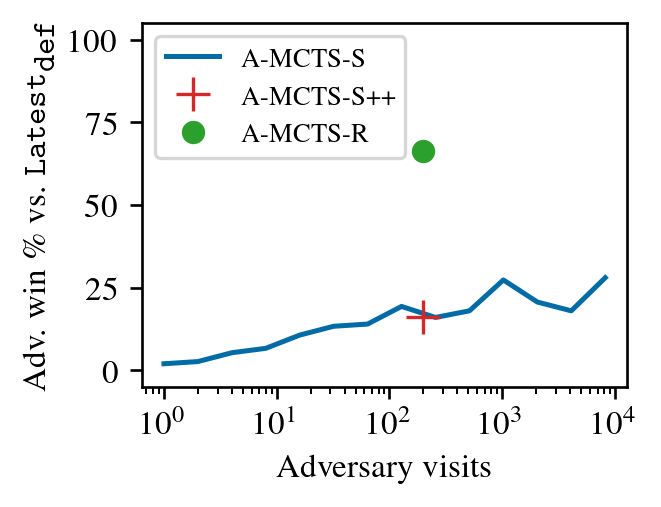

In [36]:
def make_plot(victim_visits):
    assert victim_visits in [16, 32]
    visit_query = f"victim_visits == {victim_visits}"
    gb = df2.query(visit_query).groupby("adv_name").mean(numeric_only=True).adv_win

    fig, ax = plt.subplots(
        1,
        1,
        constrained_layout=True,
        figsize=(2.64049, 2),
        dpi=240,
        gridspec_kw={"height_ratios": [10]},
    )

    (
        100
        * df.query(visit_query).groupby("adv_visits").mean(numeric_only=True).adv_win
    ).plot(label="A-MCTS-S")

    plt.plot(
        200,
        100 * gb["adv-s349284096-v200-ov1"],
        "+",
        label="A-MCTS-S++",
        markersize=10,
        color="tab:red",
    )

    plt.plot(
        200,
        100 * gb["adv-s349284096-v200"],
        "o",
        label="A-MCTS-R",
        markersize=6,
        color="tab:green",
    )

    plt.ylim(-5, 105)
    plt.xscale("log")

    # https://stackoverflow.com/a/73094650/1337463
    from matplotlib import ticker as mticker

    ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

    plt.xlabel(f"Adversary visits")
    plt.ylabel("Adv. win \\% vs. $\\texttt{Latest}_\\texttt{def}$")
    # plt.legend();
    # smaller font size to avoid covering up points
    plt.legend(prop={"size": 8})
    plt.savefig(f"adv-vs-cp505h-v{victim_visits}-vary-adv-visits.pgf", backend="pgf")


make_plot(32)

In [37]:
df.query("victim_visits == 32").groupby("adv_visits").mean(numeric_only=True).adv_win

adv_visits
1       0.020000
2       0.026667
4       0.053333
8       0.066667
16      0.106667
32      0.133333
64      0.140000
128     0.193333
256     0.160000
512     0.180000
1024    0.273333
2048    0.206667
4096    0.180000
8192    0.280000
Name: adv_win, dtype: float64

### Elo combined

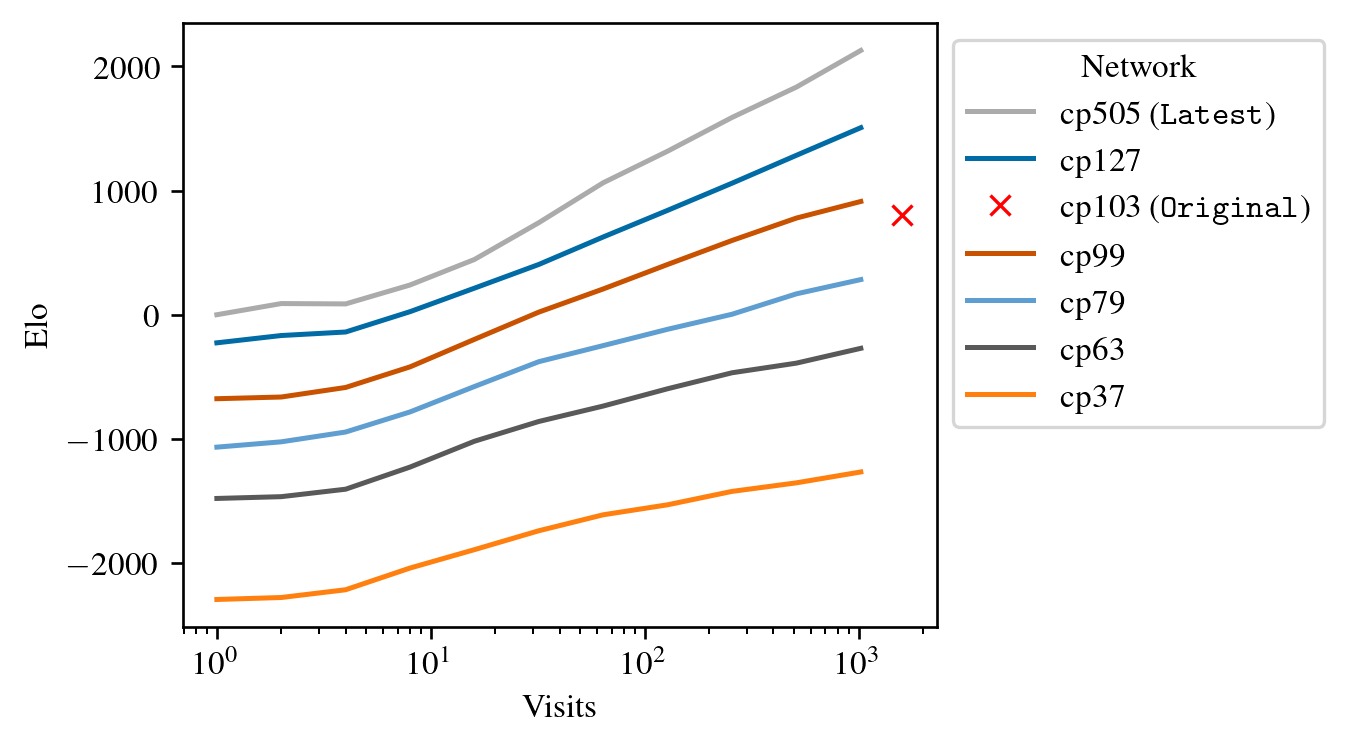

In [38]:
import pathlib
from typing import Dict, List, Union

fig, axs = plt.subplots(
    1,
    1,
    constrained_layout=True,
    figsize=(5.50107, 3),
    dpi=240,
    gridspec_kw={"height_ratios": [10]},
)
plt.subplot(1, 1, 1)

match_path = pathlib.Path("/nas/ucb/tony/go-attack/matches/visit-exp3/summary.txt")
lines = match_path.read_text().splitlines()
elo_lines_start_idx = lines.index("Elos (+/- one approx standard error):")
elo_lines_end_idx = lines.index(
    "Pairwise approx % likelihood of superiority of row over column:"
)
elo_lines = lines[elo_lines_start_idx + 1 : elo_lines_end_idx]
# elo_lines.append("cp103-v1600         :   128.86 +/- 13.25")

bot_entries: List[Dict[str, Union[float, int, str]]] = []
for elo_line in elo_lines:
    name = elo_line.split(" ")[0]
    entry = {
        "name": name,
        "rank": name[3] if "bot" in name else name.split("-")[0],
        "visits": int(name.split("-v")[1]),
        "elo": float(elo_line.split(":")[1].split("+/-")[0]) - 483.746,
        "std": float(elo_line.split("+/-")[1]) - 483.746,
    }
    if "cp127" not in entry["rank"]:
        bot_entries.append(entry)

match_path = pathlib.Path("/nas/ucb/tony/go-attack/matches/cp127-vs-cp505/summary.txt")
lines = match_path.read_text().splitlines()
elo_lines_start_idx = lines.index("Elos (+/- one approx standard error):")
elo_lines_end_idx = lines.index(
    "Pairwise approx % likelihood of superiority of row over column:"
)
elo_lines = lines[elo_lines_start_idx + 1 : elo_lines_end_idx]

for elo_line in elo_lines:
    name = elo_line.split(" ")[0]
    entry = {
        "name": name,
        "rank": name[3] if "bot" in name else name.split("-")[0],
        "visits": int(name.split("-v")[1]),
        "elo": float(elo_line.split(":")[1].split("+/-")[0]) + 591.59,
        "std": float(elo_line.split("+/-")[1]) + 591.59,
    }
    # if 'cp505' in entry['rank']:
    bot_entries.append(entry)

df = pd.DataFrame(bot_entries)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print('df', df)
for rank in sorted(df["rank"].unique()):
    df[df["rank"] == rank].groupby("visits").mean(numeric_only=True).elo.plot(
        label=rank
    )
plt.plot(1600, 800.31, "rx", label="cp103")
plt.ylabel("Elo")
plt.xlabel("Visits")
plt.xscale("log")
handles, labels = plt.gca().get_legend_handles_labels()
labels, handles = zip(
    *sorted(zip(labels, handles), key=lambda t: int(t[0].split("p")[1]))
)
handles = list(handles)[::-1]
labels = list(labels)[::-1]
labels[0] = "cp505 ($\\texttt{Latest}$)"
labels[1] = "cp127"
labels[2] = "cp103 ($\\texttt{Original}$)"
plt.legend(
    handles,
    labels,
    title="Network",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fancybox=True,
)

plt.savefig("elo-by-visits.pgf", backend="pgf")

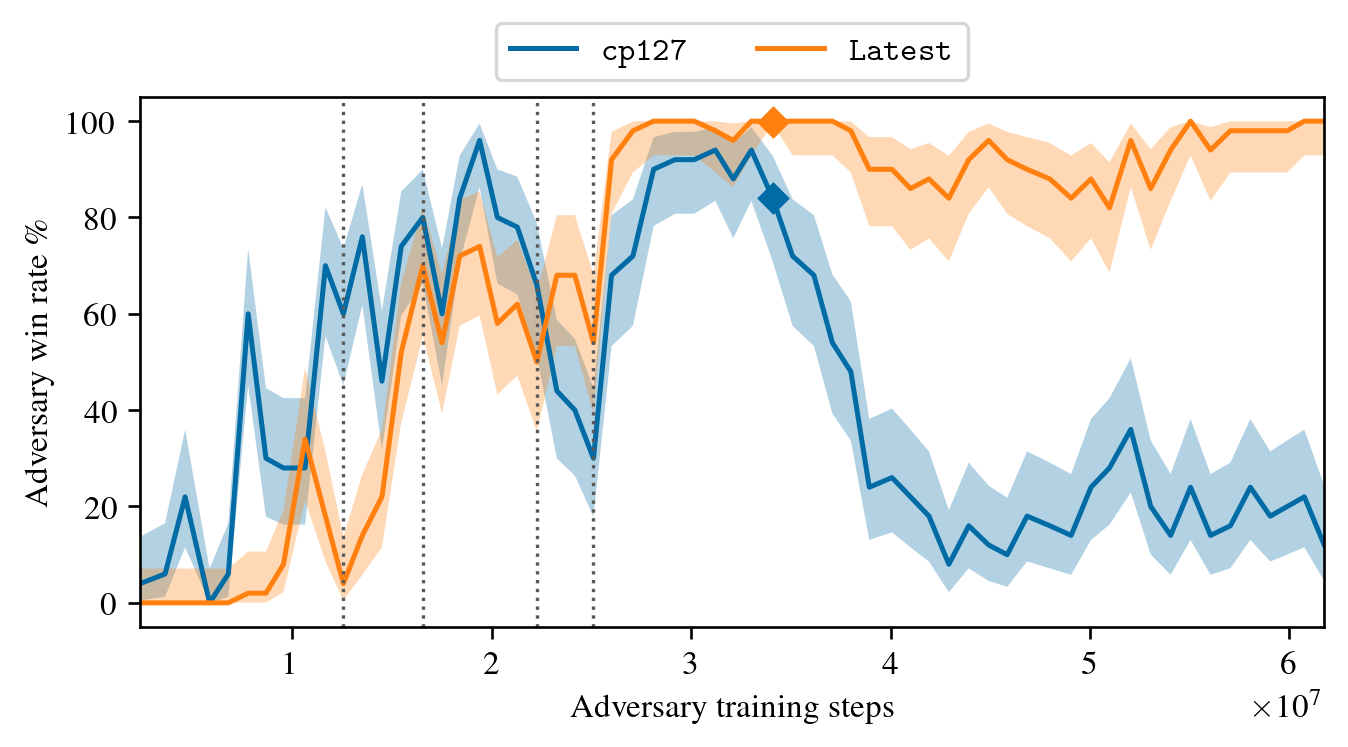

In [39]:
sgf_paths = game_info.find_sgf_files(
    pathlib.Path("/nas/ucb/ttseng/go_attack/match/adv-checkpoints")
)
game_infos = list(game_info.read_and_parse_all_files(sgf_paths, fast_parse=True))
df = pd.DataFrame(game_infos)

df19 = df.loc[df.board_size == 19]
df19 = df19.loc[df19.adv_name != "adv-s1122816-d254183-v600"]

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(5.50107, 3), dpi=240)

plt.subplot(1, 1, 1)
ALPHA = 0.05
df19["adv_win_perc"] = df.adv_win * 100
for i, v in enumerate(sorted(df19.victim_steps.unique())):
    ax = (
        df19[df19.victim_steps == v]
        .groupby("adv_steps")
        .mean(True)
        .adv_win_perc.plot(label=[r"\texttt{cp127}", r"\texttt{Latest}"][i])
    )
    victim_df = df19[df19.victim_steps == v]
    df_confint = victim_df.groupby("adv_steps").mean(True)
    conf_df = df_confint.apply(
        lambda x: proportion_confint(
            len(victim_df[(victim_df.adv_steps == x.name) & (victim_df.adv_win)]),
            len(victim_df[victim_df.adv_steps == int(x.name)]),
            alpha=ALPHA,
            method="beta",
        ),
        axis=1,
        result_type="expand",
    )
    plt.fill_between(df_confint.index, conf_df[0] * 100, conf_df[1] * 100, alpha=0.3)
    adv_pt = 34090496
    plt.plot(
        adv_pt,
        df19[df19.victim_steps == v]
        .groupby("adv_steps")
        .mean(True)
        .adv_win_perc.loc[adv_pt]
        .item(),
        "D",
        color=colors[i],
    )

x_coords = [12560640, 16541696, 22263040, 25102336]
for xc in x_coords:
    plt.axvline(x=xc, ls=":", lw=1, color=colors[3])

plt.ylabel(r"Adversary win rate \%")
plt.xlabel("Adversary training steps")
plt.margins(x=0)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncols=2, fancybox=True)

plt.savefig("adv-training.pgf", backend="pgf")

In [40]:
# note(tomtseng): this should be
# /nas/ucb/k8/go-attack/match/ttseng-hard-adv-checkpoint-sweep-20221108
# but I'm running this locally
sgf_paths = game_info.find_sgf_files(
    pathlib.Path(f"{HARDENED_PREFIX}/ttseng-hard-adv-checkpoint-sweep-20221108")
)
game_infos = list(game_info.read_and_parse_all_files(sgf_paths, fast_parse=True))
df = pd.DataFrame(game_infos)

df19 = df.loc[df.board_size == 19]
df19["adv_win_perc"] = df.adv_win * 100
len(df), len(df19)

(17585, 17585)

In [41]:
print(df19.victim_name.unique())

['cp505h-v1' 'cp127h-v1' 'cp505-v1' 'cp39h-v1' 'cp505h-v8']


In [42]:
plt.rcParams["axes.prop_cycle"].by_key()["color"]

['#006BA4',
 '#FF800E',
 '#ABABAB',
 '#595959',
 '#5F9ED1',
 '#C85200',
 '#898989',
 '#A2C8EC',
 '#FFBC79',
 '#CFCFCF']

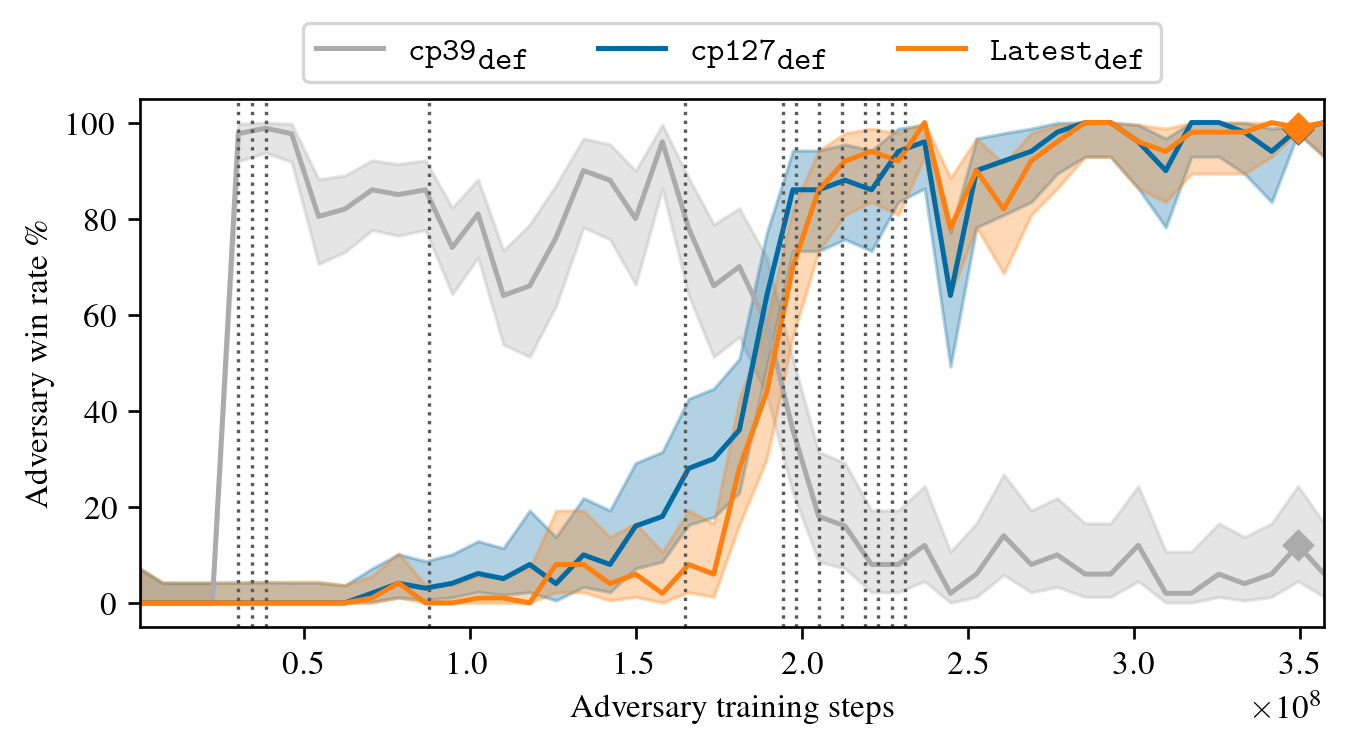

In [43]:
victim_name_to_plot_label = {
    "cp39h-v1": r"$\texttt{cp39}_\texttt{def}$",
    "cp127h-v1": r"$\texttt{cp127}_\texttt{def}$",
    "cp505-v1": r"\texttt{Latest-v1}",
    "cp505h-v1": r"$\texttt{Latest}_\texttt{def}$",
    "cp505h-v8": r"$\texttt{Latest-h-v8}_\texttt{def}$",
}
victim_names_to_plot = ["cp39h-v1", "cp127h-v1", "cp505h-v1"]
# colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# make line colors match up with unhardened reuslts
colors = ['#ABABAB', '#006BA4', '#FF800E']

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(5.50107, 3), dpi=240)

plt.subplot(1, 1, 1)
ALPHA = 0.05
for i, name in enumerate(victim_names_to_plot):
    victim_df = df19[df19.victim_name == name]
    ax = (
        victim_df.groupby("adv_steps")
        .mean(True)
        .adv_win_perc.plot(label=victim_name_to_plot_label[name], color=colors[i])
    )

    df_confint = victim_df.groupby("adv_steps").mean(True)
    conf_df = df_confint.apply(
        lambda x: proportion_confint(
            len(victim_df[(victim_df.adv_steps == x.name) & (victim_df.adv_win)]),
            len(victim_df[victim_df.adv_steps == int(x.name)]),
            alpha=ALPHA,
            method="beta",
        ),
        axis=1,
        result_type="expand",
    )
    plt.fill_between(df_confint.index, conf_df[0] * 100, conf_df[1] * 100, color=colors[i], alpha=0.3)
    adv_pt = 349284096
    plt.plot(
        adv_pt,
        victim_df.groupby("adv_steps").mean(True).adv_win_perc.loc[adv_pt].item(),
        "D",
        color=colors[i],
    )


VICTIM_RANGES = {
    "victim-kata1-b6c96-s45189632-d6589032-v1.0": (0.0, 30365184.0),
    "victim-kata1-b6c96-s69427456-d10051148-v1.0": (30365184.0, 34502144.0),
    "victim-kata1-b6c96-s175395328-d26788732-v1.0": (34502144.0, 38566400.0),
    "victim-kata1-b10c128-s197428736-d67404019-v1.0": (38566400.0, 87698176.0),
    "victim-kata1-b15c192-s497233664-d149638345-v1.0": (87698176.0, 164908288.0),
    "victim-kata1-b20c256x2-s5303129600-d1228401921-v1.0": (164908288.0, 194422784.0),
    "victim-kata1-b40c256-s5867950848-d1413392747-v1.0": (194422784.0, 198203136.0),
    "victim-kata1-b40c256-s7455877888-d1808582493-v1.0": (198203136.0, 205049600.0),
    "victim-kata1-b40c256-s9738904320-d2372933741-v1.0": (205049600.0, 212038912.0),
    "victim-kata1-b40c256-s11101799168-d2715431527-v1.0": (212038912.0, 218883584.0),
    "victim-kata1-b40c256-s11840935168-d2898845681-v1.0": (218883584.0, 223021824.0),
    "victim-kata1-b40c256-s11840935168-d2898845681-v2.0": (227013120.0, 227013120.0),
    "victim-kata1-b40c256-s11840935168-d2898845681-v4.0": (227013120.0, 230932992.0),
    "victim-kata1-b40c256-s11840935168-d2898845681-v8.0": (230932992.0, None),
}
for _, xc in list(VICTIM_RANGES.values())[:-1]:
    plt.axvline(x=xc, ls=":", lw=1, color='#595959')

plt.ylabel(r"Adversary win rate \%")
plt.xlabel("Adversary training steps")
plt.margins(x=0)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncols=3, fancybox=True)

plt.savefig("adv-training-hardened.pgf", backend="pgf")

In [44]:
for val in list(
    {
        "victim-kata1-b6c96-s45189632-d6589032-v1.0": (0.0, 30365184.0),
        "victim-kata1-b6c96-s69427456-d10051148-v1.0": (30365184.0, 34502144.0),
        "victim-kata1-b6c96-s175395328-d26788732-v1.0": (34502144.0, 38566400.0),
        "victim-kata1-b10c128-s197428736-d67404019-v1.0": (38566400.0, 87698176.0),
        "victim-kata1-b15c192-s497233664-d149638345-v1.0": (87698176.0, 164908288.0),
        "victim-kata1-b20c256x2-s5303129600-d1228401921-v1.0": (
            164908288.0,
            194422784.0,
        ),
        "victim-kata1-b40c256-s5867950848-d1413392747-v1.0": (194422784.0, 198203136.0),
        "victim-kata1-b40c256-s7455877888-d1808582493-v1.0": (198203136.0, 205049600.0),
        "victim-kata1-b40c256-s9738904320-d2372933741-v1.0": (205049600.0, 212038912.0),
        "victim-kata1-b40c256-s11101799168-d2715431527-v1.0": (
            212038912.0,
            218883584.0,
        ),
        "victim-kata1-b40c256-s11840935168-d2898845681-v1.0": (
            218883584.0,
            223021824.0,
        ),
        "victim-kata1-b40c256-s11840935168-d2898845681-v2.0": (
            227013120.0,
            227013120.0,
        ),
        "victim-kata1-b40c256-s11840935168-d2898845681-v4.0": (
            227013120.0,
            230932992.0,
        ),
        "victim-kata1-b40c256-s11840935168-d2898845681-v8.0": (230932992.0, None),
    }.values()
)[:-1]:
    print(val[1])

30365184.0
34502144.0
38566400.0
87698176.0
164908288.0
194422784.0
198203136.0
205049600.0
212038912.0
218883584.0
223021824.0
227013120.0
230932992.0


### Baseline attacks

In [45]:
edge_x, edge_y, edge_cis, edge_winrate, edge_winrate_cis = (
    np.array([2, 4, 8, 16, 32]),
    np.array([148.75, 125.57, 270.91, 311.96, 311.07]),
    np.array([32.64096667, 31.42023977, 26.51559246, 14.94472483, 16.49799086]),
    np.array([0.51, 0.57, 0.17, 0.01, 0.03]),
    np.array([0.0979804, 0.09703485, 0.07362403, 0.01950175, 0.0334351]),
)

In [46]:
mirror_x, mirror_y, mirror_cis, mirror_winrate, mirror_winrate_cis = (
    np.array([2, 4, 8, 16, 32]),
    np.array([207.19, 239.88709677, 256.18041237, 276.08646617, 253.62]),
    np.array([25.79337205, 16.40883013, 21.08132841, 12.34433871, 22.5459692]),
    np.array([0.09, 0.05069124, 0.04123711, 0.03007519, 0.04]),
    np.array([0.05609163, 0.02918747, 0.03957035, 0.02052525, 0.038408]),
)

In [47]:
spiral_x, spiral_y, spiral_cis, spiral_winrate, spiral_winrate_cis = (
    np.array([2, 4, 8, 16, 32]),
    np.array([304.79, 291.67, 323.21, 323.89, 323.67]),
    np.array([17.63109707, 22.33512761, 11.17424501, 10.9122512, 9.67025367]),
    np.array([0.06, 0.11, 0.0, 0.0, 0.0]),
    np.array([0.04654742, 0.06132639, 0.0, 0.0, 0.0]),
)

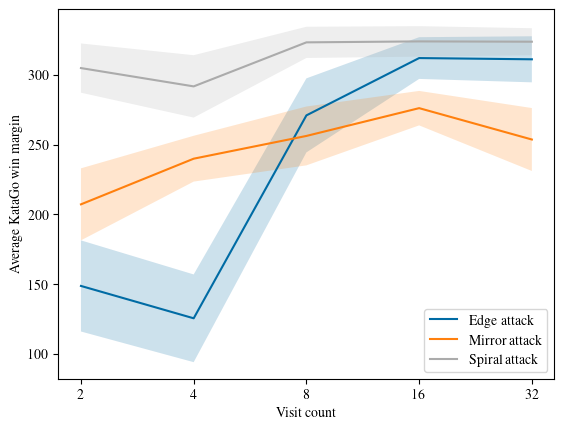

In [48]:
fig, ax = plt.subplots()
ax.set_xlabel("Visit count")
ax.set_xscale("log", base=2)
ax.set_ylabel("Average KataGo win margin")
ax.set_xticks(ticks=edge_x, labels=edge_x)
ax.plot(edge_x, edge_y, label="Edge attack")
ax.plot(mirror_x, mirror_y, label="Mirror attack")
ax.plot(spiral_x, spiral_y, label="Spiral attack")
ax.fill_between(edge_x, edge_y - edge_cis, edge_y + edge_cis, alpha=0.2)
ax.fill_between(mirror_x, mirror_y - mirror_cis, mirror_y + mirror_cis, alpha=0.2)
ax.fill_between(spiral_x, spiral_y - spiral_cis, spiral_y + spiral_cis, alpha=0.2)
ax.legend(loc="lower right")
fig.savefig("baseline-attack-win-margins.pgf", backend="pgf")

/tmp/ipykernel_29785/3693483769.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{100 * y:.0f}" for y in np.arange(0.0, 0.9, 0.1)])


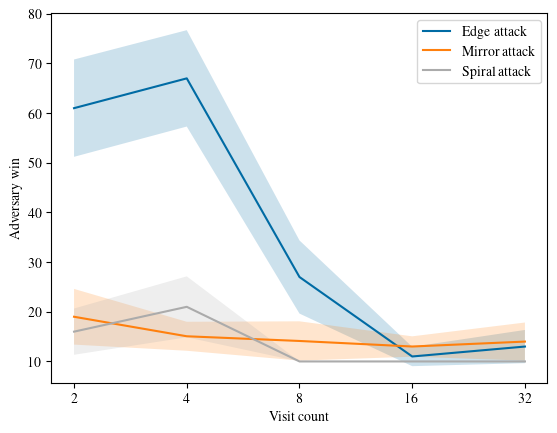

In [49]:
fig, ax = plt.subplots()
ax.set_xlabel("Visit count")
ax.set_xscale("log", base=2)
ax.set_ylabel("Adversary win %")

ax.set_xticks(ticks=edge_x, labels=edge_x)
ax.set_yticklabels([f"{100 * y:.0f}" for y in np.arange(0.0, 0.9, 0.1)])
ax.plot(edge_x, edge_winrate, label="Edge attack")
ax.plot(mirror_x, mirror_winrate, label="Mirror attack")
ax.plot(spiral_x, spiral_winrate, label="Spiral attack")
ax.fill_between(
    edge_x, edge_winrate - edge_winrate_cis, edge_winrate + edge_winrate_cis, alpha=0.2
)
ax.fill_between(
    mirror_x,
    mirror_winrate - mirror_winrate_cis,
    mirror_winrate + mirror_winrate_cis,
    alpha=0.2,
)
ax.fill_between(
    spiral_x,
    spiral_winrate - spiral_winrate_cis,
    spiral_winrate + spiral_winrate_cis,
    alpha=0.2,
)
ax.legend(loc="upper right")
fig.savefig("baseline-attack-winrates.pgf", backend="pgf")